# Audience motion, cross audience quantity of motion coherence


Generation of plots for Audience Motion paper

In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

In [3]:
%reload_ext autoreload

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [4]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [5]:
internal_Part = general_loc + 'Participants_internal/'

In [6]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [7]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
sF = 10

In [8]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [9]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
Main_concert_times['Sections']=''
for ev in evord:
    Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev[:4]),'Sections'] = ev

Main_concert_times.iloc[:5,:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence,Sections
Datetime,,,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,Claps 0,0,Clapping
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,Speech 1,1,Speech
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,Claps 1,2,Clapping
2021-10-26 17:38:59,-547.16,-547160,Speech MC1,Speech,1090.08,377.52,Speech 2,3,Speech
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,1.05,Claps 1.1,4,Clapping


In [10]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


One of the unfortunate characteristics of the cellphone measurements is their inconsistent sample rates and frequent gaps. Measurements per device were transmitted in 60 s batches, however there were (for as of yet undetermined reasons) often gaps between batches, sometimes of several seconds. These frequent discontinuities complicate how this data can be treated. Some steps taken were necessary compromises because of these measurement issues. There were also discontinuities from participants turning off the app to answer questions (remote participants only) or during intermission. To handle these gaps with care throughout these analyses, we inserted NaN values in any gaps lasting more than a second before resampling the ACC measurements to get Quantity of Motion measures on common timestamp values.

Lastly there was some data loss from phones lossing power or th app being accidentally or incidentally turned off/closed.

The individual participants accelerometer measurements during the concert experiment were resampled to matching timestamps at 50 Hz

In [11]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
    print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1) 
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

ADQ001
ADQ002
ADQ003
ADQ004
ADQ005
ADQ006
ADQ007
ADQ008
ADQ009
ADQ010
ADQ011
ADQ012
ADQ013
ADQ014
ADQ015
ADQ016
ADQ017
ADQ018
ADQ019
ADQ020
ADQ021
ADQ022
ADQ023


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

ADQ024
ADQ025
ADQ026
ADQ027
ADQ028
ADQ029
ADQ030
ADQ031
ADQ032
ADQ033
ADQ034
ADQ035
ADQ036
ADQ037
ADQ038
ADQ039
ADQ040
ADQ041
ADQ042
ADQ043
ADQ044
ADQ045
ADQ046
ADQ047
ADQ048
ADQ049
ADQ050
ADQ051
ADQ052
ADQ053
ADQ054
ADQ055
ADQ056
ADQ057
ADQ058
ADQ059
ADQ060
ADQ061
ADQ062
ADQ063
ADQ064
ADQ065
ADQ066
ADR067
ADR068
ADR069
ADR070
ADR071
AEQ077
AEQ078
AEQ079
AEQ080
AEQ081
AEQ082
AEQ083
AEQ084
AEQ085
AEQ086
AEQ087
AEQ088
AEQ089
AER090
BDQ092
BDQ093
BEQ095
BEQ096
BEQ097
BEQ098
BEQ099
BEQ100
BEQ101
BEQ102
BEQ103
BEQ104
BEQ105
BEQ106
BEQ107
BEQ108
BEQ109
BEQ110
BEQ111
BEQ112
BEQ113
BEQ114
BEQ115
BEQ116
BEQ117
BEQ118
BEQ119
BnQ131
BnQ132
BnQ133
99.83415818214417
99.89846920967102


In [12]:
aud_df.index = (ts_ct/1000).round(1) # index in seconds with one decimal
ori_aud_df = aud_df.copy()


# Pairwise Correlation averages analysis and plots

Pairwise correlations were performed on 10Hz absolute Jerk values (1st order difference of ACC resampled at 10 Hz) to assess simultaneous motion. 

First pairwise correlations between all participants were performed to assess the contribution of the shared stimulus (the music performance and conditions) across the group in when they moved more or less. 

By sitting on the chest, these sensors have a chance of catching something of head and limb movements as well has changes of position in the torso, however interpretation of the scale of these motions from the measurements is impossible when their source cannot be distinguished. For example, applause can be distinguished because the resultant sensor motion is very distinct and proportional to the intensity of clapping, at least between rounds from individual participants. In contrast, the motion resultant from answering multiple choice questions on the paper surveys was much more variable in timing, shape, and scale, including factors from their posture (leaning forward to read and write on lap or sitting straight and writing against raised paper in hand) and writing gestures (dash, checkmark, or filled square). Besides ambiguity in the types of movements behind the measurements captured, the amount of time moving was relatively low throughout the concert. Most of these measurements stayed close to the noise floor as the audience sat attentively still, with only the occasional jump of values. In otherwords, the motion signal in these measurements is very sparse, and our priority is in capturing whether any signal was occuring at the same time, not whether the movements were of a similar scale through all the ambiguities of this hanging chest acc sensor.

We opted to use the spearman correlation to capture shared motion on these time series because of the indeterminent and sparse quality of these quantity of motion signals. By using rank instead of actual measure values, the metric reduce potential scaling differences in the rare and uneven (and unevenly captured) bursts of motion, while the high frequence noise-level variation at 10 hz effectively reduces the risk of accidental inflations. In this sense, the spearman correlation values are a measure of how much simultaneous motion occurred between two people while a piece was performed (ie when moments with high rank coincided), with sensical low values for most measured events. Note that we aren't using Spearman correlations with a test of significance per pair based on the samples or duration of these time series. Spearman's rho is only a metric for how often a pair of audience members simultaneously moved, i.e. recorded jerk values above noise level, no matter the specific type of motion or gesture behind it. 

These pairwise correlations are used to test two different influences on the motion of this audience: 1) the shared stimulus/activity across the whole in-hall audience, 2) the influence of audience members on each other, given where they were seated and whether they knew each other. In both cases, we are intersted to see if the music and non-musical concert experiment events showed relatively more or less effect on coincidental motion. 

The first use of the pairwise correlations was to evaluate whether the patterns of motion reflected the shared stimulus of the performance and concert hall for in hall participants. For any given segment of the concert (2 minutes length or longer), were in hall participants significantly more simultaneous in their movements than should happen by chance? Representing the coincidental motion performed was the complete comparison set between every participant with motion measured for that same segment, for each audience member the average of their 10 Hz QoM time series correlated with every other audience members motion as sampled at that same time. To distinguish activity effects, null alternative correlation averages sets were generated with each participants's time series from one segment compared to all other in hall audience members for each other instance of the same activity: clapping with other instances of applause, music with other music, speeches with other speeches etc. For all these altenatives pairwise correlations, the longer segment signals had to be truncated to match in duration. 

A last note on interpreting coincidental motion as measured here: these signals were aligned to within 200 ms, or two samples at 10 Hz. While this too temporally blurry to capture the precision of alignment in motion between musicians, the measurable motions performed by the audience generally last more than 100 ms, giving a chance for overlap even if signal alignment is less than perfect. Again, for an evaluation of coincidental motion without focus on specific actions, this alignment quality is sufficient for capturing simultenaity between audience members.

Original analysis only performed on participants in the concert hall, as their alignment is of sufficient quality to compare at this resolution (10 Hz) and these same calculations are used to consider mutual influence between participants seated in proximity to each other.

In [14]:
hall_df = ori_aud_df.loc[:,ori_aud_df.columns.str.startswith('A')].copy()

In [15]:
partIDs = list(hall_df.columns)

Evaluate all average correlations per participant (to remaining in hall audience) and segment.

In [16]:
minDur = 60 

In [17]:
res = []
CORRS = {}
ETypes = ['Music','Survey','Speech','Applause']
method = 'spearman'

MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur')
for i,r in MTs.iterrows():
    sigs=hall_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    # remove segments that are mostly nans.
    nanratio = sigs.isna().sum()/len(sigs)
    corr1=sigs.loc[:,nanratio<0.25].corr(method='spearman')
    corr1.reset_index(drop=False,inplace=True)#.rename(columns={'index':'ID'})
    partIDs = list(corr1.columns[1:])
    K = pd.melt(corr1, id_vars=['index'], value_vars=partIDs,var_name='Pair', value_name='Spearman')
#     pd.melt(corr1, id_vars=['index'], value_vars=partIDs,var_name='Pair', value_name='Spearman')
    K['Event_Type']= r['Event_Type']
    K['Event']=r['Event']
    K['Event1']=r['Shorter_tag']

    res.append(K)
    CORRS[r['Shorter_tag']] = corr1

R = pd.concat(res, axis=0)
R = R.reset_index(drop=True)
Q = R.loc[R['Spearman'].notna(),:].query('index!=Pair') # remove nans and identities
Q.loc[:5,:]   

,index,Pair,Spearman,Event_Type,Event,Event1
1,ADQ003,ADQ001,-0.100363,Speech,Speech,Speech 1
2,ADQ004,ADQ001,-0.000815,Speech,Speech,Speech 1
3,ADQ005,ADQ001,-0.068802,Speech,Speech,Speech 1
4,ADQ006,ADQ001,0.090462,Speech,Speech,Speech 1
5,ADQ007,ADQ001,0.123552,Speech,Speech,Speech 1


In [18]:
G = pd.DataFrame(columns = ['Participant_Code','Event_Type','Event','Event1','Correlations'])
evs = Q['Event1'].unique()
k=0
for ev in evs:
    F = Q.query('Event1==@ev')
    parts = F['index'].unique()
    for partID in parts:
        E = F.query('index==@partID')
        row = E.iloc[0,:]
        G.loc[k,'Participant_Code'] = partID
        G.loc[k,'Event_Type'] = row['Event_Type']
        G.loc[k,'Event1'] = row['Event1']
        G.loc[k,'Event'] = row['Event']
        G.loc[k,'Correlations'] = E['Spearman'].mean()
        k+=1

evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping', ]
for ev in evord:
    G.loc[G['Event1'].str.startswith(ev[:4]),'Sections1'] = ev
G.loc[:5,:]

,Participant_Code,Event_Type,Event,Event1,Correlations,Sections1
0,ADQ003,Speech,Speech,Speech 1,0.002749,Speech
1,ADQ004,Speech,Speech,Speech 1,0.033861,Speech
2,ADQ005,Speech,Speech,Speech 1,0.045351,Speech
3,ADQ006,Speech,Speech,Speech 1,0.020064,Speech
4,ADQ007,Speech,Speech,Speech 1,-0.003752,Speech
5,ADQ008,Speech,Speech,Speech 1,0.009158,Speech


In [231]:
G.to_csv('QoM_meanrho.csv')

Reserve pairwise correlations between participants for near and select relationships.

In [533]:
Sub_Rels = pd.read_csv('./data/Audience/Sub_Relationships_Hall_Rand_Distant.csv', index_col=0)
Sub_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
909,ADQ003,ADQ008,4.0,0,Stranger
910,ADQ003,ADQ048,4.0,0,Stranger
911,ADQ055,ADQ059,4.0,0,Stranger
912,ADQ043,ADQ060,4.0,0,Stranger


In [534]:
ev = 'Music'
A=Q.copy()

for ev in evord:
    A.loc[A['Event1'].str.startswith(ev[:4]),'Sections'] = ev
A.loc[:,'Relationship'] = ''
A.loc[:,'Familiarity'] = 0
A.loc[:,'Distance'] = np.nan
A.loc[:,'Close'] = 0


for i,rel in Sub_Rels.iterrows():
    p1 = rel["Participant_Code_1"]
    p2 = rel["Participant_Code_2"]
    V = A.query('index==@p1 and Pair==@p2')
    A.loc[V.index,'Relationship']=rel['Relationship']
    A.loc[V.index,'Familiarity']=rel['Familiarity']
    A.loc[V.index,'Distance']=rel['Distance']
    if rel['Distance']<4.0:
        A.loc[V.index,'Close']=1
# C = A.query('Close==1').copy()
# C.to_csv('pairwiseRelsRandDist.csv')
C = A.query('Distance>-3').copy()
C.to_csv('pairwiseRelsRandDist.csv')

### Alternative pairwise comparisons for mean rho 

Generate the set of alternatives and truncated thrue correlations for each segment, by comparing to others in the same category of events, looking only at participants who are active for at least 75% of the event interval and only if the alternative segment is at least 40% of the duration of the reference segment.

This threshold, 40% looks low, but it's necessary for the smaller set of segments being evaluated here (60 s), between surveys and clapping intervals and speechs. This however does help restrict comparisons for the music intervals. The last alternative is to estimate the standard deviation reduction of longer intervals and scale alternatives accordingly. Which could work and be mathematically legit, but would probably be a lot to explain in the text. 

In [212]:
res = []
ETypes = ['Music','Survey','Speech','Applause'] #
method = 'spearman'

MTs = Main_concert_times.query('Event_Type in @ETypes and Event_Duration > @minDur').reset_index()
for i,r in MTs.iterrows():
    sigs1=hall_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    nanratio1 = sigs1.isna().sum()/len(sigs1)
    sigs1 = sigs1.loc[:,nanratio1<0.25].copy()
    partIDs1 = sigs1.columns
    for j,q in MTs.iterrows():
        if r['Event_Type'] == q['Event_Type']:
            if r['Shorter_tag'] != q['Shorter_tag']:
                sigs2=hall_df.loc[q['Time_s']:q['Time_s']+q['Event_Duration'],:].copy()
                nanratio2 = sigs2.isna().sum()/len(sigs2)
                sigs2 = sigs2.loc[:,nanratio2<0.25].copy()
                partIDs2 = sigs2.columns
                L = np.min([len(sigs1),len(sigs2)])-1
                parts = list(set(partIDs1) & set(partIDs2))
                if L>len(sigs1)*0.4: # one instance from the shorter survey at 0.5 exactly
                    corr1 = pd.concat([sigs1.loc[:,parts].iloc[:L,:].reset_index(drop=True),sigs2.loc[:,parts].iloc[:L,:].reset_index(drop=True)],axis=1).corr(method='spearman')
                    corr2 = corr1.iloc[len(parts):,:len(parts)].reset_index(drop=False).copy().rename(columns={"index": "PartID"})
                    K = pd.melt(corr2, id_vars=['PartID'], value_vars=parts,var_name='PairID', value_name='Spearman_alt')
                    K['Event_Type']= r['Event_Type']
                    K['Event1']=r['Shorter_tag']
                    K['Event2']=q['Shorter_tag']
                    # within event signal corr of the same duration on the true set
                    corr3 = pd.concat([sigs1.loc[:,parts].iloc[:L,:].reset_index(drop=True),sigs1.loc[:,parts].iloc[:L,:].reset_index(drop=True)],axis=1).corr(method='spearman')
                    corr4 = corr3.iloc[len(parts):,:len(parts)].reset_index(drop=False).copy().rename(columns={"index": "PartID"})
                    Ktrue = pd.melt(corr4, id_vars=['PartID'], value_vars=parts,var_name='PairID', value_name='Spearman_true')
                    K['Spearman_true'] = Ktrue['Spearman_true'] 
                    res.append(K.query('PartID!=PairID')) #skip identity match in alt and in true 

R = pd.concat(res, axis=0)
R = R.reset_index(drop=True)
Qalt = R.loc[R['Spearman_alt'].notna(),:].copy()
Qalt = Qalt.loc[Qalt['Spearman_true'].notna(),:].copy()
Qalt.loc[:5,:] 

,PartID,PairID,Spearman_alt,Event_Type,Event1,Event2,Spearman_true
0,ADR070,ADQ049,0.029137,Speech,Speech 1,Speech 2,0.002209
1,ADQ009,ADQ049,-0.067161,Speech,Speech 1,Speech 2,0.060936
2,ADQ063,ADQ049,0.021014,Speech,Speech 1,Speech 2,0.014499
3,ADQ022,ADQ049,0.112186,Speech,Speech 1,Speech 2,0.087705
4,ADR068,ADQ049,0.070528,Speech,Speech 1,Speech 2,0.070353
5,ADQ028,ADQ049,0.045644,Speech,Speech 1,Speech 2,0.003005


In [213]:
Qalt.to_csv('Paired_alts_full.csv')

In [215]:
evs = Qalt['Event1'].unique()
ev1 = 'Claps 5'
ev2 = 'Claps 14'
D = Qalt.query('Event1==@ev1') # 9650 
F = D.query('Event2==@ev2') # 9650 rows × 7 columns same because they are the same length
F

,PartID,PairID,Spearman_alt,Event_Type,Event1,Event2,Spearman_true
474720,ADQ009,ADR070,0.141150,Applause,Claps 5,Claps 14,0.285693
474721,ADQ004,ADR070,0.111131,Applause,Claps 5,Claps 14,-0.063597
474722,ADQ063,ADR070,0.196400,Applause,Claps 5,Claps 14,0.240621
474723,ADR068,ADR070,0.041197,Applause,Claps 5,Claps 14,0.208103
474724,ADQ028,ADR070,0.082433,Applause,Claps 5,Claps 14,-0.000626
...,...,...,...,...,...,...,...
478137,ADQ046,ADQ023,0.028379,Applause,Claps 5,Claps 14,0.131350
478138,ADQ042,ADQ023,0.084233,Applause,Claps 5,Claps 14,-0.242498
478139,ADQ012,ADQ023,0.046748,Applause,Claps 5,Claps 14,0.180660
478140,ADQ059,ADQ023,0.102118,Applause,Claps 5,Claps 14,0.274020


In [218]:
Galt = pd.DataFrame(columns = ['Participant_Code','Event_Type','Event1','Event2','Correlations_alt','Correlations_true'])
evs = list(set(Qalt['Event1'].unique()) & set(Qalt['Event2'].unique())) + list(set(Qalt['Event1'].unique()) ^ set(Qalt['Event2'].unique()))
k=0
for ev1 in evs:
    D = Qalt.query('Event1==@ev1')
    for ev2 in evs:
        F = D.query('Event2==@ev2')
        parts = F['PartID'].unique()
        for partID in parts:
            E = F.query('PartID==@partID')
            row = E.iloc[0,:]
            Galt.loc[k,'Participant_Code'] = partID
            Galt.loc[k,'Event_Type'] = row['Event_Type']
            Galt.loc[k,'Event1'] = row['Event1']
            Galt.loc[k,'Event2'] = row['Event2']
            Galt.loc[k,'Correlations_alt'] = E['Spearman_alt'].mean()
            Galt.loc[k,'Correlations_true'] = E['Spearman_true'].mean()
            k+=1
Galt.iloc[:5,:]

,Participant_Code,Event_Type,Event1,Event2,Correlations_alt,Correlations_true
0,ADR070,Speech,Speech 7,Speech 1,0.034497,0.062944
1,ADQ009,Speech,Speech 7,Speech 1,-0.016745,0.042077
2,ADQ004,Speech,Speech 7,Speech 1,0.010894,0.058921
3,ADQ022,Speech,Speech 7,Speech 1,0.018955,0.030678
4,ADQ063,Speech,Speech 7,Speech 1,-0.041109,-0.052489


In [219]:
# check for redudancies
Galt.query('Event1=="Claps 5" and Event2=="Claps 14" and Participant_Code=="ADQ009"')

,Participant_Code,Event_Type,Event1,Event2,Correlations_alt,Correlations_true
6982,ADQ009,Applause,Claps 5,Claps 14,0.019108,0.118052


In [220]:
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']
Galt['Sections1'] = ''
Galt['Sections2'] = ''
for ev in evord:
    Galt.loc[Galt['Event1'].str.startswith(ev[:4]),'Sections1'] = ev
    Galt.loc[Galt['Event2'].str.startswith(ev[:4]),'Sections2'] = ev
Galt.iloc[:5,:]

,Participant_Code,Event_Type,Event1,Event2,Correlations_alt,Correlations_true,Sections1,Sections2
0,ADR070,Speech,Speech 7,Speech 1,0.034497,0.062944,Speech,Speech
1,ADQ009,Speech,Speech 7,Speech 1,-0.016745,0.042077,Speech,Speech
2,ADQ004,Speech,Speech 7,Speech 1,0.010894,0.058921,Speech,Speech
3,ADQ022,Speech,Speech 7,Speech 1,0.018955,0.030678,Speech,Speech
4,ADQ063,Speech,Speech 7,Speech 1,-0.041109,-0.052489,Speech,Speech


In [221]:
Galt.to_csv('altQoM_pairwise_narrowed40p_truedur.csv')

From the original pairings, tag the pairings that will be used for the spatial and relationships analysis to follow and save the results

In [23]:
Galt= pd.read_csv('altQoM_pairwise_narrowed40p_truedur.csv',index_col=0)
Galt['Correlations_alt'] = Galt['Correlations_alt'].astype('float')
Galt['Correlations_true'] = Galt['Correlations_true'].astype('float')


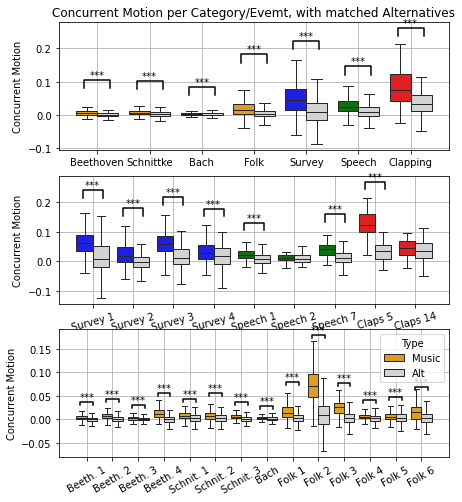

In [230]:
fig, axes= plt.subplots(3,1,figsize=(7, 8))

ax = axes[0]
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']
for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs_alt['Correlations'] =MeanCorrs_alt['Correlations_alt'] 
    MeanCorrs = Galt.query('Event_Type==@ets').copy()
    MeanCorrs['Correlations'] = MeanCorrs['Correlations_true'] 
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Sections1', y='Correlations', order = evord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False,ax=ax)
ax.grid()
# ax.legend(['Music','Survey','Speech','Applause','Alt'],loc='upper left')

for i in range(len(evord)):
    ev = evord[i]
    Gset = Galt.query('Sections1==@ev')
#     Gset = pd.concat([Galt.query('Sections1==@ev and Sections2==@ev'),Galt.query('Sections1==@ev and Sections2!=@ev'),Galt.query('Sections1!=@ev and Sections2==@ev')],axis=0)
    C = Gset['Correlations_true'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(evord),0.5)-0.25,np.ones(len(evord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(evord)),evord,rotation=0)

#
ax  = axes[1]

ETypes = ['Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
# musord=G.query('Event_Type!="Music"')['Event1'].unique()
# musord = ['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4','Speech 1', 'Speech 2', 'Speech 3', 
#        'Speech 6',  'Speech 7', 'Speech 9', 'Claps 4','Claps 5', 'Claps 14']
musord = ['Survey 1','Survey 2','Survey 3','Survey 4','Speech 1', 'Speech 2', 'Speech 7','Claps 5','Claps 14']
for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs_alt['Correlations'] =MeanCorrs_alt['Correlations_alt'] 
    MeanCorrs = Galt.query('Event_Type==@ets').copy()
    MeanCorrs['Correlations'] = MeanCorrs['Correlations_true'] 
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False, ax=ax)

for i in range(len(musord)):
    ev = musord[i]
    Gset = Galt.query('Event1==@ev')
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    C = Gset['Correlations_true'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(musord)),musord,rotation=15)
ax.grid()

#
ax = axes[2]
ets = 'Music'
MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
MeanCorrs_alt['Type'] = 'Alt'
MeanCorrs_alt['Correlations'] = MeanCorrs_alt['Correlations_alt'] 
MeanCorrs = Galt.query('Event_Type==@ets').copy()
MeanCorrs['Correlations'] = MeanCorrs['Correlations_true'] 
MeanCorrs['Type'] = ets
MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
musord=G.query('Event_Type=="Music"')['Event1'].unique()
sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue = 'Type', hue_order=['Music','Alt'], 
               showfliers = False, palette=events_palette, ax=ax)
for i in range(len(musord)):
    ev = musord[i]
    Gset = Galt.query('Event1==@ev')
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    C = Gset['Correlations_true'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(musord)),musord,rotation=30)
ax.grid()
axes[0].set_title('Concurrent Motion per Category/Event, with matched Alternatives')
plt.savefig('./plots/Figure_Corrs_Alt_durTur.png', bbox_inches = 'tight',dpi = 196)

plt.show()

In [229]:
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']

for i in range(len(evord)):
    ev = evord[i]
    Gset = Galt.query('Sections1==@ev')
#    Gset = pd.concat([Galt.query('Event1==@ev and Event2==@ev'),Galt.query('Event1==@ev and Event2!=@ev'),Galt.query('Event1!=@ev and Event2==@ev')],axis=0)
    ac = pg.ttest(Gset['Correlations_true'].astype(float),Gset['Correlations_alt'].astype(float),paired=True,alternative='greater')
    pval = ac['p-val'].values[0]
    print([ev,Gset['Correlations_true'].mean(),Gset['Correlations_alt'].mean()])
    print(ac)

['Beethoven', 0.006580394822194426, 0.0002774713441268401]
                T   dof alternative          p-val        CI95%   cohen-d  \
T-test  31.770908  3604     greater  8.199144e-196  [0.01, inf]  0.757064   

              BF10  power  
T-test  4.719e+191    1.0  
['Schnittke', 0.007222890486825178, 0.00243005921704858]
                T   dof alternative         p-val       CI95%   cohen-d  \
T-test  18.745592  2547     greater  7.491664e-74  [0.0, inf]  0.513904   

             BF10  power  
T-test  1.129e+70    1.0  
['Bach', 0.0022717060255848503, 0.0009823199757968072]
               T  dof alternative         p-val       CI95%   cohen-d  \
T-test  4.957957  581     greater  4.681360e-07  [0.0, inf]  0.290509   

             BF10  power  
T-test  1.485e+04    1.0  
['Folk', 0.02327789428723538, 0.00404264669664462]
                T   dof alternative  p-val        CI95%   cohen-d BF10  power
T-test  40.778282  5388     greater    0.0  [0.02, inf]  0.743815  inf    1.0
['Sur

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/bayesian.py:152: RuntimeWarning: overflow encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


Now plot and mark the t-test comparisons between the correlations between participants, true and null/alternative, evaluating which intervals of the concert showed shared patterns of motion. 

## parallel analysis of the mean rho true and alt, but with full duration correlations 

Differences in results between this two sample unpair t-test between full duration cross-audience correlations and the preceeding paired matched duration cross-audience correlation averages are consistent with expectations. This one may be more tolerable because sample independence is more definitive, though I am more confident in the results of the preceeding and have no issue with the sampling idependence in the paired ttest version. After all, what is beign tested is the difference between matched mean rho values against zero mean and not their respective distibutions. 

In [11]:
G = pd.read_csv('QoM_pairwise.csv',index_col=0)
Galt= pd.read_csv('altQoM_pairwise_narrowed40p.csv',index_col=0)

In [12]:
# why pandas do you suddenly fail to recognise consistent data types within columns?
G['Correlations'] = G['Correlations'].astype('float')
Galt['Correlations'] = Galt['Correlations'].astype('float')


In [13]:
Galt.loc[Galt['Event1']==ev,'Correlations']
ev

'Clapping'

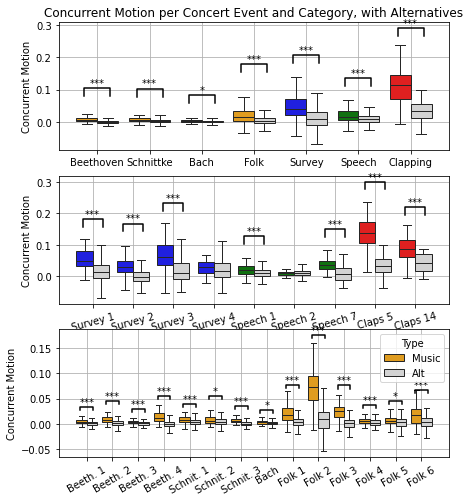

In [545]:
fig, axes= plt.subplots(3,1,figsize=(7, 8))
ax = axes[0]
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']

for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs = G.query('Event_Type==@ets').copy()
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Sections1', y='Correlations', order = evord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False,ax=ax)
ax.grid()
# ax.legend(['Music','Survey','Speech','Applause','Alt'],loc='upper left')

for i in range(len(evord)):
    ev = evord[i]
    ac = pg.ttest(G.loc[G['Sections1']==ev,'Correlations'],Galt.loc[Galt['Sections1']==ev,'Correlations'],alternative='greater')
    C = G.loc[G['Sections1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(evord),0.5)-0.25,np.ones(len(evord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(evord)),evord,rotation=0)

#
ax  = axes[1]

ETypes = ['Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
# musord=G.query('Event_Type!="Music"')['Event1'].unique()
# musord = ['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4','Speech 1', 'Speech 2', 'Speech 3', 
#        'Speech 6',  'Speech 7', 'Speech 9', 'Claps 4','Claps 5', 'Claps 14']
musord = ['Survey 1','Survey 2','Survey 3','Survey 4','Speech 1', 'Speech 2', 'Speech 7','Claps 5','Claps 14']
for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs = G.query('Event_Type==@ets').copy()
    MeanCorrs['Type'] = ets
    MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
    sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue_order=[ets,'Alt'], 
            showfliers = False,  hue = 'Type', palette=events_palette, legend=False, ax=ax)

for i in range(len(musord)):
    ev = musord[i]
    ac = pg.ttest(G.loc[G['Event1']==ev,'Correlations'],Galt.loc[Galt['Event1']==ev,'Correlations'],alternative='greater')
    C = G.loc[G['Event1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(musord)),musord,rotation=15)
ax.grid()

#
ax = axes[2]
ets = 'Music'
MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
MeanCorrs_alt['Type'] = 'Alt'
MeanCorrs = G.query('Event_Type==@ets').copy()
MeanCorrs['Type'] = ets
MeanCorrs = pd.concat([MeanCorrs,MeanCorrs_alt],axis=0)
musord=G.query('Event_Type=="Music"')['Event1'].unique()
sns.boxplot(data=MeanCorrs, x='Event1', y='Correlations', order = musord, hue = 'Type', hue_order=['Music','Alt'], 
               showfliers = False, palette=events_palette, ax=ax)
for i in range(len(musord)):
    ev = musord[i]
    ac = pg.ttest(G.loc[G['Event1']==ev,'Correlations'],Galt.loc[Galt['Event1']==ev,'Correlations'],alternative='greater')
    C = G.loc[G['Event1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    if pval<0.05:
        am.axbarplot_annotate_brackets(ax,2*i,(2*i)+1,pval,np.arange(0,len(musord),0.5)-0.25,np.ones(len(musord)*2)*C, yerr=None, dh=.05, barh=.025, fs=None, maxasterix=3)
ax.set(xlabel=None)
ax.set(ylabel='Concurrent Motion')
ax.set_xticks(np.arange(len(musord)),musord,rotation=30)
ax.grid()
axes[0].set_title('Concurrent Motion per Concert Event and Category, with Alternatives')
plt.savefig('./plots/Figure_Corrs_Alt.png', bbox_inches = 'tight',dpi = 196)

plt.show()

In [543]:
ETypes = ['Music','Survey','Speech','Applause']
events_palette={'Music':'orange','Applause':'red','Speech':'green','Survey':'blue','Alt':'lightGray'}
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk',  'Survey','Speech', 'Clapping']

for i in range(len(evord)):
    ev = evord[i]
    ac = pg.ttest(G.loc[G['Sections1']==ev,'Correlations'],Galt.loc[Galt['Sections1']==ev,'Correlations'],alternative='greater')
    C = G.loc[G['Sections1']==ev,'Correlations'].astype('float').quantile(0.97)
    pval = ac['p-val'].values[0]
    print([ev,G.loc[G['Sections1']==ev,'Correlations'].mean()])
    print(ac)

['Beethoven', 0.007299365068562629]
                T         dof alternative         p-val        CI95%  \
T-test  13.901524  340.105642     greater  2.107933e-35  [0.01, inf]   

         cohen-d       BF10  power  
T-test  1.050871  1.653e+40    1.0  
['Schnittke', 0.0076040113456556846]
               T         dof alternative         p-val       CI95%   cohen-d  \
T-test  5.689736  272.474916     greater  1.640063e-08  [0.0, inf]  0.361858   

             BF10    power  
T-test  1.176e+06  0.99988  
['Bach', 0.002786081656546847]
              T         dof alternative     p-val       CI95%   cohen-d  \
T-test  1.67154  150.640359     greater  0.048345  [0.0, inf]  0.161263   

         BF10     power  
T-test  1.026  0.361831  
['Folk', 0.024013518150553876]
                T         dof alternative         p-val        CI95%  \
T-test  12.875577  469.489731     greater  5.301527e-33  [0.02, inf]   

         cohen-d       BF10  power  
T-test  1.003207  1.777e+34    1.0  
['Sur

## Cross audience mean rho against ratings 

This analysis is a bit wonky because meanrho is not a good measure of concurrent motion between pieces, specifically the effect of duration and the total quantity of motion. At best it should replicated the Folk/classical difference. But it's worth checking to conform the relationship.



There is no robust relationship between mean rho and body awareness or judgements of own motion during classical pieces, like with average quantity of motion. During classical music, the shared patterns of motion are not a product of or conditional on self-awareness. 

The lack of distinction for own motion judgments over classical and folk conditions reinforces this disconnect. How well people moved with each other is not result of conscious control and active voluntary motion. That isn't to say no moments of concurrent motion were under audience members control or awareness, but these were not persistent conditions that differentiated participants coordination with the music/whole audience.

In [14]:
ETypes = ['Music']
evord = ['Beethoven', 'Schnittke', 'Bach', 'Folk']

for ets in ETypes:
    MeanCorrs_alt = Galt.query('Event_Type==@ets').copy()
    MeanCorrs_alt['Type'] = 'Alt'
    MeanCorrs = G.query('Event_Type==@ets').copy()
    MeanCorrs['Type'] = ets

# ax.legend(['Music','Survey','Speech','Applause','Alt'],loc='upper left')


In [24]:
partID = 'ADQ003'
music='Beethoven'
MeanCorrs.query('Participant_Code==@partID and Sections1==@music').loc[:,'Correlations'].max()

0.0158838673757367

In [26]:
parts

array(['ADQ003', 'ADQ004', 'ADQ005', 'ADQ006', 'ADQ007', 'ADQ008',
       'ADQ009', 'ADQ010', 'ADQ011', 'ADQ012', 'ADQ013', 'ADQ014',
       'ADQ015', 'ADQ016', 'ADQ018', 'ADQ019', 'ADQ020', 'ADQ021',
       'ADQ022', 'ADQ023', 'ADQ024', 'ADQ025', 'ADQ026', 'ADQ027',
       'ADQ028', 'ADQ029', 'ADQ030', 'ADQ031', 'ADQ032', 'ADQ033',
       'ADQ034', 'ADQ035', 'ADQ036', 'ADQ037', 'ADQ038', 'ADQ039',
       'ADQ040', 'ADQ041', 'ADQ042', 'ADQ043', 'ADQ044', 'ADQ045',
       'ADQ046', 'ADQ047', 'ADQ048', 'ADQ049', 'ADQ050', 'ADQ051',
       'ADQ052', 'ADQ053', 'ADQ054', 'ADQ055', 'ADQ056', 'ADQ057',
       'ADQ058', 'ADQ059', 'ADQ060', 'ADQ061', 'ADQ062', 'ADQ063',
       'ADQ064', 'ADQ065', 'ADQ066', 'ADR067', 'ADR068', 'ADR069',
       'ADR070', 'ADR071', 'AEQ077', 'AEQ078', 'AEQ079', 'AEQ080',
       'AEQ081', 'AEQ082', 'AEQ083', 'AEQ084', 'AEQ085', 'AEQ087',
       'AEQ088', 'AEQ089', 'AER090', 'ADQ001', 'ADQ002', 'ADQ017',
       'AEQ086'], dtype=object)

In [29]:
parts = MeanCorrs['Participant_Code'].unique()
df = mm_df.query("ParticipantCode in @parts").copy()
df['meanmeanrho'] = np.nan
df['maxmeanrho'] = np.nan

for i, row in df.iterrows():
    partID = row['ParticipantCode']
    music = row['Music']
    rhos = MeanCorrs.query('Participant_Code==@partID and Sections1==@music').loc[:,'Correlations']
    if len(rhos)>0:
        df.loc[i,'meanmeanrho'] = rhos.mean()
        df.loc[i,'maxmeanrho'] = rhos.max()


In [38]:
CORRED = df.loc[~df['meanmeanrho'].isna(),:].copy().reset_index(drop=True)
sub_H = CORRED.copy()

In [42]:
CORRED

,ParticipantCode,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Stimuli_N,Motion_seen,Motion_seen_Max,meanmeanrho,maxmeanrho
0,ADQ001,Hall,Beethoven,0.397257,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,1.0,0.732901,0.823137,0.009986,0.026878
1,ADQ003,Hall,Beethoven,0.541163,Continuously,Yes and I moved a normal amount,Not aware of others' movement,1.0,0.599071,0.761768,0.007721,0.015884
2,ADQ004,Hall,Beethoven,0.583683,Not at all,Yes and I moved less than usual,Not aware of others' movement,1.0,0.550443,0.618796,0.005324,0.008716
3,ADQ005,Hall,Beethoven,0.420638,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,1.0,0.323668,0.323668,0.006882,0.013488
4,ADQ006,Hall,Beethoven,0.621689,Continuously,Yes and I moved less than usual,Not aware of others' movement,1.0,0.541771,0.656923,0.007534,0.017517
...,...,...,...,...,...,...,...,...,...,...,...,...
309,AEQ086,Hall,Folk,0.476186,Continuously,Yes and I moved less than usual,Yes and they moved a normal amount,4.0,0.831774,0.879416,0.013244,0.078911
310,AEQ087,Hall,Folk,0.369035,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount,4.0,0.503115,0.635328,0.030316,0.097952
311,AEQ088,Hall,Folk,0.424374,Rarely,Yes and I moved a normal amount,Not aware of others' movement,4.0,0.682980,0.682980,0.000451,0.012259
312,AEQ089,Hall,Folk,0.656402,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount,4.0,0.514305,0.527574,0.016773,0.030905


In [36]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body_Bach', 'aware_movement_Bach', 'aware_others_moving_Bach', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']

sub_text = Quest_text.loc[Quest_text['ID'].isin(sub_Q_List),:]
sub_text.set_index('ID',drop=True,inplace = True)
# sub_text

In [60]:
tag_Q = 'aware_body'
tag_m = 'meanmeanrho' #'mQoM''meanmeanrho' 
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)

Were you aware of your physical body during this piece?


Aware of physical body...
       Source  ddof1      ddof2         F     p-unc      np2
0  aware_body      3  88.093379  3.280896  0.024611  0.04586
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.015831  0.009592  0.006239  0.002471   
1    Continuously      Not at all  0.015831  0.006993  0.008838  0.002821   
2    Continuously          Rarely  0.015831  0.010151  0.005680  0.002582   
3  Intermittently      Not at all  0.009592  0.006993  0.002599  0.001761   
4  Intermittently          Rarely  0.009592  0.010151 -0.000560  0.001346   
5      Not at all          Rarely  0.006993  0.010151 -0.003159  0.001914   

          T          df      pval    hedges  
0  2.525199   49.472948  0.068263  0.557568  
1  3.133376   65.274170  0.013465  0.687268  
2  2.199452   57.877358  0.135531  0.477912  
3  1.476006   43.415219  0.460423  0.266111  
4 -0.415697  165.028296  0.975725 -0.056283  
5 -1.650174   56.794293  0.359409 -0

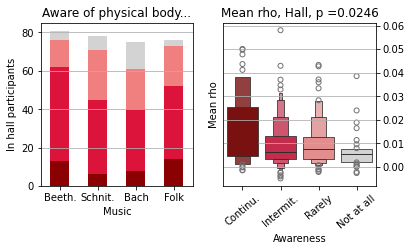

In [63]:
print(QuT)
QuT = 'Aware of physical body...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Continuously','Intermittently','Rarely','Not at all']
short_responses = ['Continu.','Intermit.','Rarely','Not at all']
resp_map = {'Continuously':'Continu.','Intermittently':'Intermit.','Rarely':'Rarely','Not at all':'Not at all'}

my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df.rename(columns=resp_map,inplace=True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend=False,color = my_pal.values(),ax = ax1)
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(tracks_tag)
ax1.set_title(QuT)
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')
# fig.legend(loc='center right',ncol=3,fontsize = 8)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED)
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED))

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = CORRED, ax = ax2)
ax2.set_xticks([0,1,2,3])
# ax2.set_xticklabels(short_responses,labelrotation='20')
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_xlabel('Awareness')
ax2.set_ylabel('Mean rho')
ax2.set_title('Mean rho, Hall, p =' + str(aov['p-unc'].values[0].round(4)))
ax2.yaxis.tick_right()
# ax2.set_ylim([0,1.5])
ax2.grid(axis='y')

# plt.savefig('./plots/body_aware_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
#fig.legend(labels = feats, loc='center right', ncol=3,fontsize = 8)

plt.show()

Aware of physical body...
       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  65.199005  1.199363  0.317035  0.018159
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.007150  0.005562  0.001588  0.001292   
1    Continuously      Not at all  0.007150  0.005139  0.002011  0.001574   
2    Continuously          Rarely  0.007150  0.006742  0.000408  0.001416   
3  Intermittently      Not at all  0.005562  0.005139  0.000423  0.001076   
4  Intermittently          Rarely  0.005562  0.006742 -0.001180  0.000828   
5      Not at all          Rarely  0.005139  0.006742 -0.001603  0.001223   

          T          df      pval    hedges  
0  1.229145   32.315254  0.613308  0.319878  
1  1.277278   49.290831  0.581518  0.344286  
2  0.288014   44.557117  0.991559  0.069396  
3  0.393241   34.399879  0.979038  0.090366  
4 -1.425613  101.900234  0.486432 -0.238172  
5 -1.311041   51.861777  0.560209 

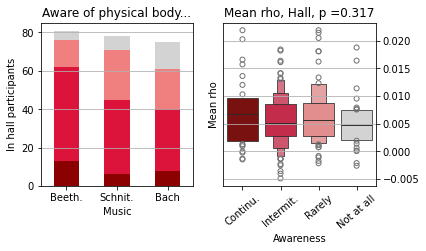

In [68]:
print(QuT)
QuT = 'Aware of physical body...' 

tracks = ['Beethoven','Schnittke','Bach']
tracks_tag = ['Beeth.','Schnit.','Bach']

response_order = ['Continuously','Intermittently','Rarely','Not at all']
short_responses = ['Continu.','Intermit.','Rarely','Not at all']
resp_map = {'Continuously':'Continu.','Intermittently':'Intermit.','Rarely':'Rarely','Not at all':'Not at all'}

my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df.rename(columns=resp_map,inplace=True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend=False,color = my_pal.values(),ax = ax1)
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(tracks_tag)
ax1.set_title(QuT)
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')
# fig.legend(loc='center right',ncol=3,fontsize = 8)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks')))

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = CORRED.query('Music in @tracks'), ax = ax2)
ax2.set_xticks([0,1,2,3])
# ax2.set_xticklabels(short_responses,labelrotation='20')
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_xlabel('Awareness')
ax2.set_ylabel('Mean rho')
ax2.set_title('Mean rho, Hall, p =' + str(aov['p-unc'].values[0].round(4)))
ax2.yaxis.tick_right()
# ax2.set_ylim([0,1.5])
ax2.grid(axis='y')

# plt.savefig('./plots/body_aware_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
#fig.legend(labels = feats, loc='center right', ncol=3,fontsize = 8)

plt.show()

In [55]:
aov['p-unc'].values[0].round(4)

0.0246

In [84]:
tag_Q = 'aware_movement'
# tag_m = 'meanmeanrho'
tag_m = 'maxmeanrho'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)
QuT = 'Relative to your own usual behaviour...' 


Were you aware of your own physical movement during this piece? If so, how much did you move relative to your own usual behaviour at this kind of concert?


           Source  ddof1       ddof2          F     p-unc       np2
0  aware_movement      3  127.369229  10.844287  0.000002  0.145548
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.018848   
1            Not aware of movement  Yes and I moved less than usual  0.018848   
2            Not aware of movement  Yes and I moved more than usual  0.018848   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.025241   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.025241   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.016092   

    mean(B)      diff        se         T          df      pval    hedges  
0  0.025241 -0.006394  0.004769 -1.340715  100.239066  0.539406 -0.217872  
1  0.016092  0.002756  0.004694  0.587010   93.037784  0.935774  0.106990  
2  0.053760 -0.034912  0.007425 -4.701966   81.254695  0.000061 -0.9

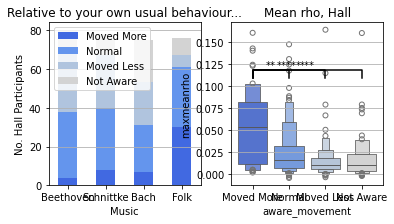

In [85]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid(axis='y')
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = CORRED.query('Music in @tracks'), ax = ax2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses)

print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks')))

ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [0.1,0.1,0.1,0.1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax2.set_title('Mean rho, Hall')
ax3.set_ylim([0,0.07])
ax2.grid(axis='y')
# plt.savefig('./plots/body_move_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()


Own relative movement...
           Source  ddof1      ddof2         F     p-unc       np2
0  aware_movement      3  68.573064  0.757282  0.521938  0.010484
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.009609   
1            Not aware of movement  Yes and I moved less than usual  0.009609   
2            Not aware of movement  Yes and I moved more than usual  0.009609   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.012383   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.012383   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.011009   

    mean(B)      diff        se         T          df      pval    hedges  
0  0.012383 -0.002773  0.001870 -1.483386   83.969143  0.452011 -0.271918  
1  0.011009 -0.001400  0.001845 -0.758556   80.100118  0.872735 -0.145733  
2  0.011192 -0.001583  0.002798 -0.565865   33.

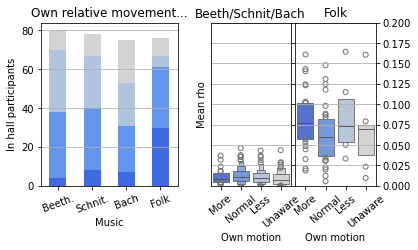

In [87]:
print(QuT)
QuT = 'Own relative movement...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['More','Normal','Less','Unaware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H.query('Music==@t')[tag_Q].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

fig = plt.figure(figsize=(6,3))
gridspec.GridSpec(1,4)

# large subplot
ax1 = plt.subplot2grid((1,12), (0,0), colspan=5, rowspan=1)

#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1,legend=False)
#ax1.legend(loc="best")
ax1.grid(axis='y')
#ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticklabels(tracks_tag,rotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')

tracks = ['Beethoven','Schnittke','Bach',]
aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)
ax2 = plt.subplot2grid((1,12), (0,6), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data=CORRED.query('Music in @tracks'), ax = ax2)
#ax2.set_title('Mean QoM, Hall, p>.3')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax2.set_ylim([0,0.2])
ax2.yaxis.tick_right()
ax2.set_yticklabels([])
ax2.set_ylabel('Mean rho')

ax2.set_xlabel('Own motion')
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_title('Beeth/Schnit/Bach')
ax2.grid(axis='y')

tracks = ['Folk']
aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(aov)
ax3 = plt.subplot2grid((1,12), (0,9), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data=CORRED.query('Music in @tracks'), ax = ax3)
#ax3.set_title('Mean QoM, Hall, p<.05')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=CORRED.query('Music in @tracks'))
print(ac)
ls = pd.Series(response_order)
for i,row in ac.iterrows():
    if row.pval<0.05:
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], row.pval,[0,1,2,3], [1.2,1.1,1.0,0.9], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)

ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels(short_responses,rotation=40)
ax3.set_ylim([0,0.2])
ax3.set_ylabel('')
ax3.set_xlabel('Own motion')
ax3.yaxis.tick_right()
ax3.set_title('Folk')
ax3.grid(axis='y')
# plt.savefig('./Plots/body_move_A_R_qom_less.png',bbox_inches = 'tight',dpi = 196)

plt.show()



This analysis is shared for accountability but not actually exposing of anything new or contrary to the information generated from simpler analyses, so it can just stay here. 